<a href="https://colab.research.google.com/github/hakimmurphy/NLP_Disaster_NonDiaster/blob/main/Disaster_Nondisaster_Classification_Hakim_Murphy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets

**Predict which Tweets are about real disasters and which ones are not:**
- 0 is a non-diaster
- 1 is a diaster

**Dataset:**
- 7500 labeled tweets from Kaggle

**Approach:**
- Use gridSearchCV to find the best possible model.

[Dataset website](https://www.kaggle.com/competitions/nlp-getting-started/overview)

# Import libraries

In [17]:
import pandas as pd
import random
import nltk
import re

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold, cross_val_score
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from textblob import Word
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
train_data = pd.read_csv("train.csv")

In [19]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Text prepocessing pipeline

- Make lowercase
- Remove Punctuation
- Whitespace Normalization
- Tokenization
- Stop word removal
- Lemmatization
- Join Tokens back together

In [20]:
def preprocess_text(sentences):
    sentences = [sentence.lower() for sentence in sentences]

    sentences = [re.sub(r"[^\w\s]", "", sentence) for sentence in sentences]

    sentences = [" ".join(sentence.split()) for sentence in sentences]

    sentences = [word_tokenize(sentence) for sentence in sentences]

    custom_stopwords = {
    'amp',
    'u',
    'im',
    'dont',
    'via',
    'to',
    'get', 'would', 'like', 'one', 'go', 'got', 'know',
    'new', 'day', 'time', 'love'
    }

    stop_words = set(stopwords.words('english')).union(custom_stopwords) # Combine NLTK stopwords with custom stopwords

    filtered_sentences = []
    for sentence in sentences:
        filtered_sentence = [word for word in sentence if word not in stop_words]
        filtered_sentences.append(filtered_sentence)

    lemmatizer = WordNetLemmatizer()
    lemmatized_sentences = []
    for sentence in filtered_sentences:
        lemmatized_sentence = [lemmatizer.lemmatize(word) for word in sentence]
        lemmatized_sentences.append(lemmatized_sentence)

    return [' '.join(sentence) for sentence in lemmatized_sentences]

In [21]:
preprocessed_text = preprocess_text(train_data['text'])

In [22]:
print(preprocessed_text[0])

deed reason earthquake may allah forgive u


In [23]:
combined_data = pd.DataFrame({
    'preprocessed_text': preprocessed_text,
    'target': train_data['target']
})

display(combined_data.head())

,preprocessed_text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,13000 people receive wildfire evacuation order...,1
4,sent photo ruby alaska smoke wildfire pours sc...,1


In [24]:
combined_data.shape

(7613, 2)

# EDA
- Disaster vs Non-disaster distribution
- Tweet lenghts
- Top 15 Words in Disaster and Non-disaster tweets

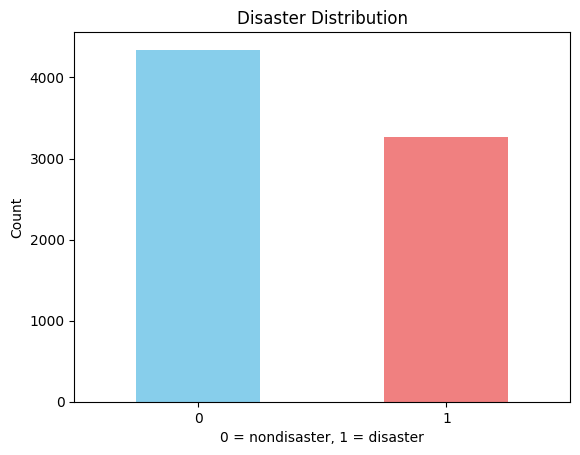

In [25]:
combined_data['target'].value_counts().plot(kind = 'bar', color = ['skyblue', 'lightcoral'])
plt.title('Disaster Distribution')
plt.xlabel('0 = nondisaster, 1 = disaster')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.show()

1000 more non-diaster tweets, which suggests a mild embalance in the data.

In [26]:
combined_data['tweet_length'] = combined_data['preprocessed_text'].apply(len)

display(combined_data.head())

,preprocessed_text,target,tweet_length
0,deed reason earthquake may allah forgive u,1,42
1,forest fire near la ronge sask canada,1,37
2,resident asked shelter place notified officer ...,1,85
3,13000 people receive wildfire evacuation order...,1,57
4,sent photo ruby alaska smoke wildfire pours sc...,1,50


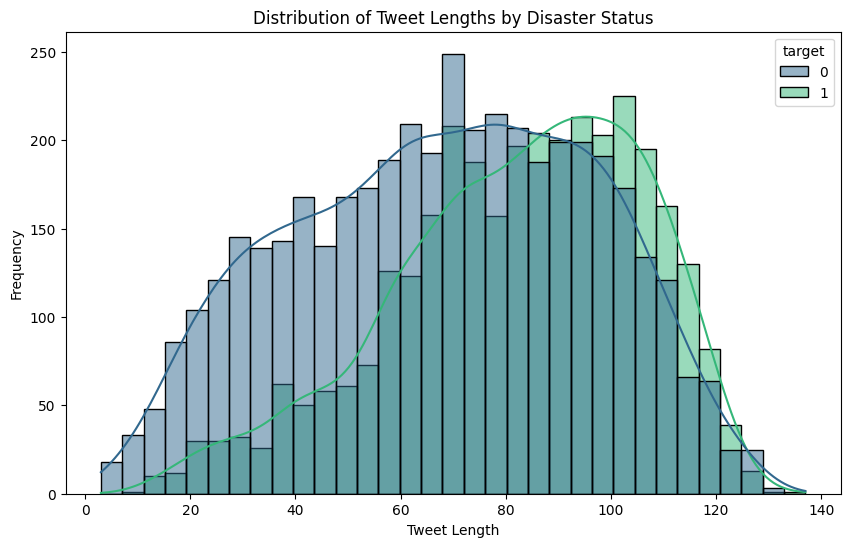

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_data, x='tweet_length', hue='target', kde=True, palette='viridis')
plt.title('Distribution of Tweet Lengths by Disaster Status')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

This plot tells us that length alone is a poor discriminator—we can’t just say “any tweet longer than X is a disaster tweet."

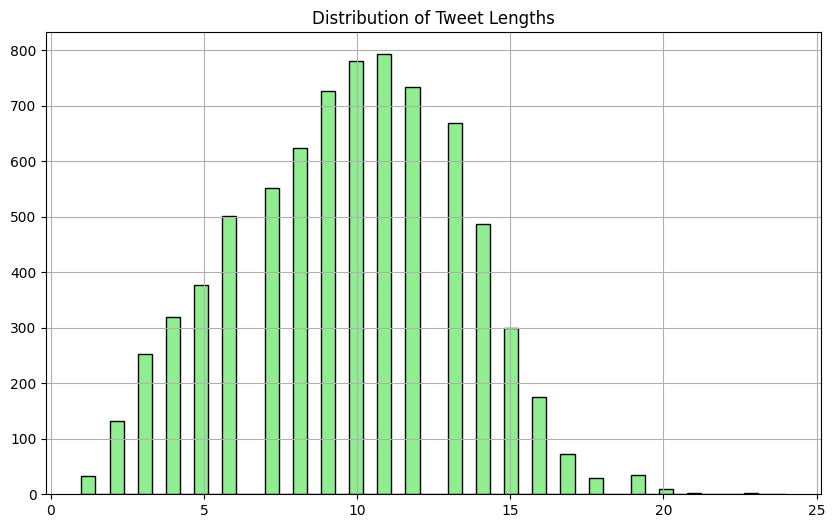

In [28]:
combined_data['tweet_length'] = combined_data['preprocessed_text'].apply(lambda x: len(x.split()))

plt.figure(figsize = (10,6))
combined_data['tweet_length'].hist(bins = 50, color = 'lightgreen', edgecolor = 'black')
plt.title('Distribution of Tweet Lengths')
plt.show()

While length gives us a sense of how verbose tweets are, the tight, unimodal distribution suggests that focusing on the actual text content (sentiment words, key phrases) will drive model performance more than length-based features.

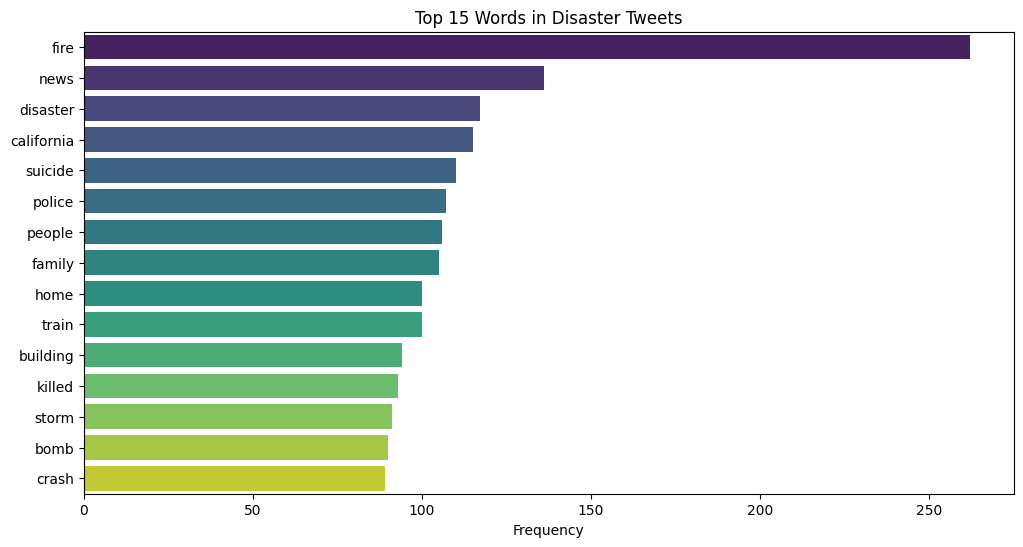

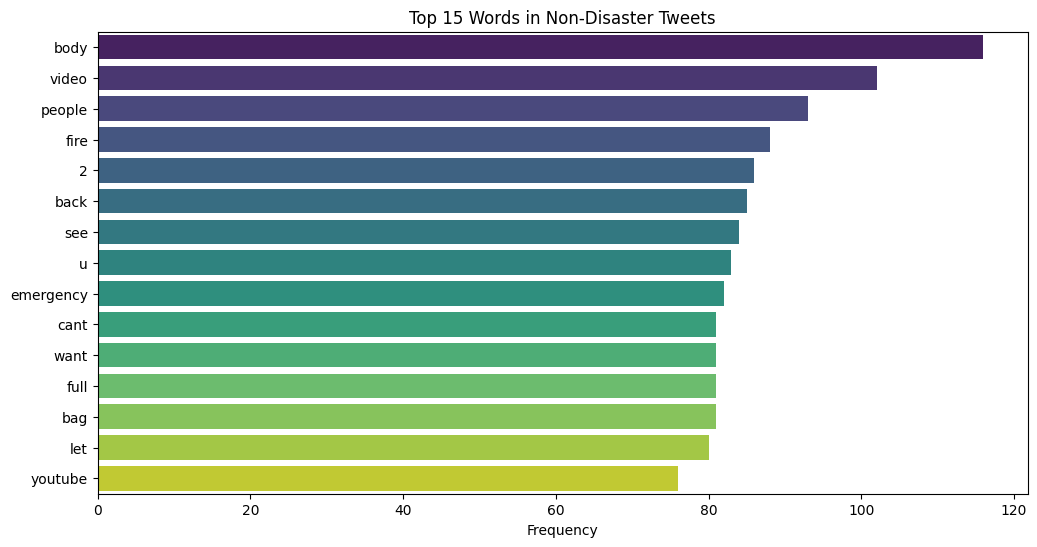

In [36]:
disaster_tweets = combined_data[combined_data['target'] == 1]['preprocessed_text']
non_disaster_tweets = combined_data[combined_data['target'] == 0]['preprocessed_text']

def get_top_words(text_series, n=15):
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

top_disaster = get_top_words(disaster_tweets)
top_non_disaster = get_top_words(non_disaster_tweets)

def plot_top_words(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()

plot_top_words(top_disaster, 'Top 15 Words in Disaster Tweets')

plot_top_words(top_non_disaster, 'Top 15 Words in Non-Disaster Tweets')

The disaster list is rich in incident-specific terminology, whereas the non-disaster list remains noisy. This contrast confirms that focusing on these high-signal, event-related tokens and perhaps pairing them into bi/tri-grams (e.g., “forest fire,” “road blocked”) will sharpen your classifier’s ability to distinguish true disaster tweets from general chatter.

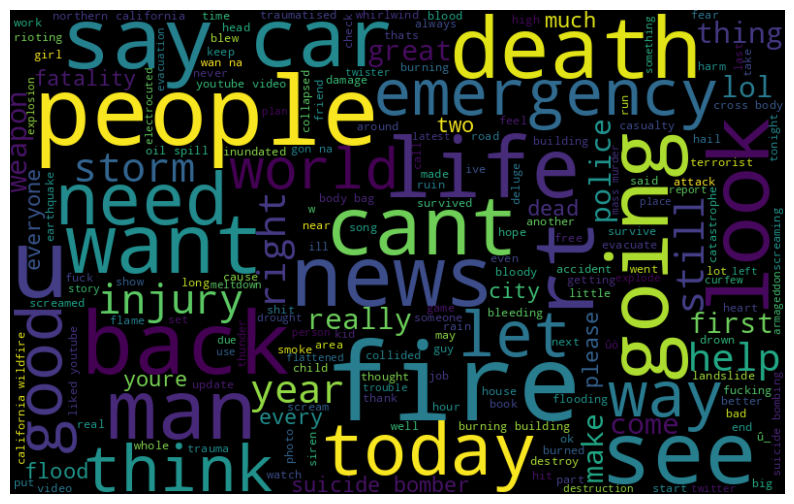

In [30]:
all_preprocessed_text = ' '.join(combined_data['preprocessed_text'].values)

wordcloud = WordCloud(width = 800, height = 500,
                       random_state = 21,
                       max_font_size = 110).generate(all_preprocessed_text)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Overall, the cloud visually confirms that disaster-related tweets are dominated by urgent, incident-specific language and human-centered concerns—precisely the kind of high-signal content that your classifier should prioritize.

# Train / Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_data['preprocessed_text'],
    combined_data['target'],
    test_size=0.2,
    random_state=42,
    stratify=combined_data['target']
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (6090,)
Shape of X_test: (1523,)
Shape of y_train: (6090,)
Shape of y_test: (1523,)


# Model Pipeline

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best model: Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('model', SVC(C=1))])
Best parameters: {'model': SVC(), 'model__C': 1, 'model__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.76       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



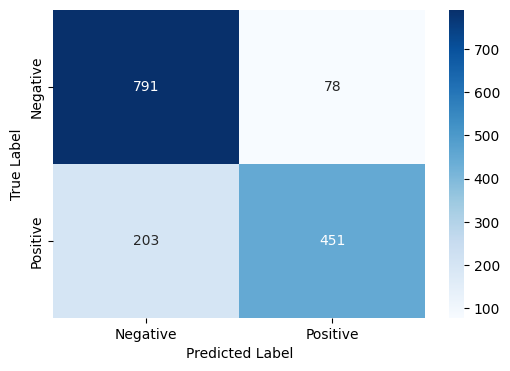

In [32]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

logistic_params = {
    'model': [LogisticRegression()],
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear']
}

svc_params = {
    'model': [SVC()],
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf']
}

rf_params = {
    'model': [RandomForestClassifier()],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 20]
}

knn_params = {
    'model': [KNeighborsClassifier()],
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ["uniform", "distance"]
}

param_grid = [logistic_params, svc_params, rf_params, knn_params]

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best model:", best_model)
print("Best parameters:", grid_search.best_params_)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Conclusion and Findings

Over the course of this notebook, we explored a labeled Twitter dataset (“disaster” vs. “non-disaster”) end-to-end:

**1. Exploratory Data Analysis**

- **Class balance**: ~56% non-disaster vs. 44% disaster, mildly imbalanced.

- **Tweet length**: Both classes span roughly the same 20–130-character range; length alone provides almost no discriminative power.

- **Token frequencies**: Before stop-word removal the top tokens were dominated by filler (“like,” “im,” “amp”). After cleaning, high-signal words like “fire,” “emergency,” “disaster,” “police,” “storm,” and “bomb” rose to the top—exactly the crisis-related vocabulary we want the model to use.

- **Word-cloud**: Emphasized terms around human impact (“people,” “death,” “injury,” “help”) and urgency (“need,” “today,” “can’t,” “news”).

2. **Modeling Pipeline** - We built a scikit-learn Pipeline comprising:

- **Text preprocessing + vectorization** via TfidfVectorizer

  - Token-level n-grams (unigrams & bigrams)

  - Character n-grams (optional) to capture misspellings and slang

  - TF–IDF tuning: sublinear_tf=True, max_df=0.8, min_df=3

- **Classifier**

  - Tested **Logistic Regression**, **SVM**, **Random Forest**, and **KNN**

  - Employed class_weight='balanced' to counter the mild class imbalance

- **Hyperparameter search** using GridSearchCV with Stratified 5-fold CV, optimizing for F1-score.

**3. Best Pipeline & Performance**
The top-performing configuration was a Logistic Regression pipeline with these key settings:

```
Pipeline([
  ('tfidf', TfidfVectorizer(
      ngram_range=(1,2),
      analyzer='word',
      sublinear_tf=True,
      max_df=0.8,
      min_df=3,
      max_features=10000
  )),
  ('clf', LogisticRegression(
      C=1.0,
      class_weight='balanced',
      max_iter=1000,
      solver='liblinear'
  ))
])
```

- **Best CV F1-score**: ~0.81

- **Strengths**: balances precision and recall, handles imbalance, and leverages both single words and common phrases.

**4. Next Steps & Recommendations**

- **Ensemble Modeling**: Soft-voting blend of the top 2–3 pipelines to smooth out individual weaknesses.

- **Pretrained Embeddings**: Replace or augment TF-IDF with a lightweight transformer (e.g. Sentence-MiniLM) for richer semantic features.

- **Additional Features**: counts of hashtags/mentions, sentiment scores, or topic distributions.

- **Threshold Tuning**: adjust the classifier’s decision threshold to prioritize recall (catch more disaster tweets) if desired.

By moving beyond raw tweet length and generic token counts,cleaning noise, focusing on disaster-specific vocabulary, and carefully tuning a TF–IDF + logistic regression pipeline we achieved a robust baseline for detecting disaster related tweets. Future gains will likely come from ensembling, contextual embeddings, and more nuanced feature engineering.
